# DNN Model

Objectives of the notebook:
- Experiement with dense neural network
- Train the model
- Evluation of the model
- Get inference pipeline

## Load Dataset

In [2]:
import pandas as pd
df_mod = pd.read_excel("df_mod.xlsx")

## Preprocessing

### Fixing class imbalance

- sentiment_majority == "positive" ~ 0
- sentiment_majority == "negative" ~ 1
- sentiment_majority == "neutral" ~ 2

In [3]:
df_positive = df_mod[df_mod['sentiment_numeric'] == 0]
df_positive.shape

(214, 4)

In [4]:
df_negative = df_mod[df_mod['sentiment_numeric'] == 1]
df_negative.shape

(73, 4)

In [5]:
df_neutral = df_mod[df_mod['sentiment_numeric'] == 2]
df_neutral.shape

(241, 4)

We can see that negative sample size is much lower than other classes. So, we are going to upsample this class.

In [6]:
df_negative_upsampled = df_negative.sample(df_positive.shape[0], replace = True)
df_negative_upsampled.shape

(214, 4)

In [7]:
df_balanced = pd.concat([df_positive, df_negative_upsampled, df_neutral])
df_balanced.sentiment_numeric.value_counts()

2    241
0    214
1    214
Name: sentiment_numeric, dtype: int64

### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['review'], 
                                                    df_balanced['sentiment_numeric'], 
                                                    stratify=df_balanced['sentiment_numeric'],
                                                    test_size = .2)

In [9]:
len(y_train), len(y_test)

(535, 134)

In [10]:
y_train.unique(), y_test.unique()

(array([1, 2, 0]), array([2, 0, 1]))

## Dependency Install

In [ ]:
!pip install tensorflow-text
!pip install fire
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q -U tf-models-official==2.7.0
!pip install -U tfds-nightly

## Imports

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
# !pip install tensorflow-text
import tensorflow_text as text

## Model

In [ ]:
# bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
bert_preprocess = hub.KerasLayer( "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=False)

In [63]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(256, activation="relu")(l)
l = tf.keras.layers.Dense(64, activation="relu")(l)
l = tf.keras.layers.Dense(3, activation="softmax", name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [65]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [66]:
checkpoint_path = '/content/drive/MyDrive/project/uiu_project/data_analytics_project/model/model2'

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

In [67]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [68]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[cp_callback])

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.1584 - accuracy: 0.3421
Epoch 1: saving model to /content/drive/MyDrive/project/uiu_project/data_analytics_project/model/model2
17/17 [==============================] - 16s 716ms/step - loss: 1.1584 - accuracy: 0.3421 - val_loss: 1.0984 - val_accuracy: 0.3657
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.0768 - accuracy: 0.4112
Epoch 2: saving model to /content/drive/MyDrive/project/uiu_project/data_analytics_project/model/model2
17/17 [==============================] - 12s 717ms/step - loss: 1.0768 - accuracy: 0.4112 - val_loss: 1.0577 - val_accuracy: 0.4552
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.0650 - accuracy: 0.4262
Epoch 3: saving model to /content/drive/MyDrive/project/uiu_project/data_analytics_project/model/model2
17/17 [==============================] - 11s 654ms/step - loss: 1.0650 - accuracy: 0.4262 - val_loss: 1.0742 - val_accuracy: 0.4179
Epoch 4/50

### Plot Model Training Metrics

<Axes: title={'center': 'Model Training Metrics'}>

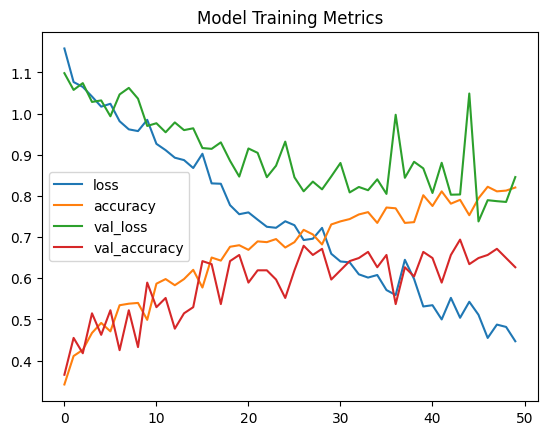

In [69]:
pd.DataFrame(history.history).plot(title="Model Training Metrics")

# Evaluation

In [22]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 253ms/step - loss: 0.8028 - accuracy: 0.6642


[0.8028169870376587, 0.6641790866851807]

# Inference

- sentiment_majority == "positive" ~ 0
- sentiment_majority == "negative" ~ 1
- sentiment_majority == "neutral" ~ 2

In [51]:
list(X_test)[0:10]

['অনলাইনে অর্ডার করতে পারেন যেকোন ফুড ডেলিভারি এপ্স আর ডাইন ইন তো চালুই আছে।',
 'কোনও জ্বালা বা ব্রণ ছাড়াই এটি যতটা চাই ততই কমিয়ে দিতে পারি এবং আমি অবশ্যই আজীবন গ্রাহক',
 'ঈদের আগে পেলে বেশি খুশি হতাম..',
 'আমি গতকাল রিসিভ করেছি',
 'ওজ ক্যাফের পথচলাই শুরু করেছে আপনাদেরকে ফ্রেন্ডলি বাজেটে এক জায়গার ভিতরেই খাবার এবং বিনোদনের সর্বোচ্চ সুবিধা দিতে।।।',
 'ফার্স্ট ইমপ্রেশনেই তো নেগেটিভ হবে মানুষ।',
 'প্রথমত তাদের খাবার আমার কাছে অনেক ভালো লাগছে',
 'আমি আমার অফিসের জন্য কয়েকটা কিনেছি',
 'খাবার এর কথা বলি আমি শুরু করেছি কাবাব আর নান দিয়ে।',
 'খুবই ভালো সার্ভিস দিচ্ছে']

In [52]:
list(y_test)[0:10]

[2, 0, 2, 2, 2, 2, 0, 2, 2, 0]

In [53]:
np.argmax(np.array(model.predict(list(X_test)[0:10])), axis = 1)

array([0, 2, 0, 0, 2, 2, 0, 2, 2, 0])

In [59]:
def number_to_text(number):
    if number == 0:
        return "positive"
    elif number == 1:
        return "negative"
    elif number == 2:
        return "neutral"

In [62]:
reviews = [
    "আলহামদুলিল্লাহ ঠিক ভাবে পেয়েচি ঘড়িটা আর এটার চায তেমন থাকে না আর এমেইতে ঠিক আচে।",
    "বাজে একটা জিনিস",
    "বাজেট অনুযায়ী অনেক ভাল একটি প্রোডাক্ট।সেলাররা এরকম প্রোডাক্ট প্রোভাইড করলে আশা করি মানুষদের অনলাইনে প্রোডাক্ট কেনার ইচ্ছে আরো বাড়বে,বিশেষ করে অবশ্যই দারাজে।ধন্যবাদ সেলার এবং দারাজকে।"
]
for each_number in np.argmax(np.array(model.predict(reviews)), axis = 1):
    print(number_to_text(each_number))

neutral
positive
positive
